### 0. Dependencies

In [23]:
import numpy as np
import time
import matplotlib.pyplot as plt 
import pandas as pd 

### 0.5 Prepare Input: Item-User Matrix  

In [24]:
df = pd.read_csv('data_test.csv')
df = df.sample(frac = 0.45) 
df = df[['userId', 'movieId', 'rating']]
df.head()

,userId,movieId,rating
5243,105,44665,5.0
17741,422,3798,2.0
6213,368,2126,2.0
14544,125,99813,4.5
222,514,8906,2.0


In [25]:
min(df['rating'])

0.5

In [26]:
df.shape

(9075, 3)

### Function 0: Pivot to get Item-User Matrix (Q)

In [27]:
def pivot(df):
    Q = (df.pivot(index='movieId', columns='userId', values='rating')).fillna(0)
    return Q

In [28]:
Q = pivot(df)
Q.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Hyper-parameters

In [29]:
lambda_ = 0.0002
n_factors = 10
m, n = Q.shape
n_iterations = 20

### Function 1: Prepare X_tilde that incorporates biases 

In [30]:
def prep_X_tilde(n_factors, m):
    'n_factors: NUM OF LATENT VARIABLES.'
    'm: NUMBER OF ROWS OF ITEM-USER MATRIX.'
    
    'OUTPUT: X_tilde'
    
    ## Initialize X
    X = 5 * np.random.rand(m, n_factors)  
    
    ## Initialize B_u
    B_u = np.random.rand(m, 1) 
    
    ## Produce X_tilde
    X_ones = np.ones((m,1))
    X_tilde = np.hstack((X_ones, B_u, X))
    
    return X_tilde

In [31]:
## test
X_test = prep_X_tilde(n_factors, m)
X_test.shape

(3487, 12)

### Funciton 2: Prepare Y_tilde

In [32]:
def prep_Y_tilde(n_factors, n):
    'n_factors: NUM OF LATENT VARIABLES.'
    'n: NUMBER OF COLS OF ITEM-USER MATRIX.'
    
    'OUTPUT: Y_tilde'
    
    ## Initialize Y
    Y = 5 * np.random.rand(n_factors, n)
    
    ## Initialize B_i
    B_i = np.random.rand(1, n)
    
    ## Produce Y_tilde
    Y_ones = np.ones((1,n))
    Y_tilde = np.vstack((B_i, Y_ones, Y))
    
    return Y_tilde

In [33]:
## test
Y_test = prep_Y_tilde(n_factors, n)
Y_test.shape

(12, 590)

### Function 3: ALS + R1 + R2

In [34]:
def ALS_r1_r2(lambda_, n_factors, n_iterations, X, Y, Q):
    'lambda_: HP TO CONTROL REGULARIZATION.'
    'n_factors: NUM OF LATENT VARIABLES.'
    'n_iterations: NUM OF ITERATIONS.'
    'X: PREPARED X_TILDE.'
    'Y: PREPARED Y_TILDE.'
    'Q: PIVOTED ITEM-USER "MATRIX". However, here Q is still a DATAFRAME.'
    
    'OUTPUT: weighted_errors (a list of RMSE to each iteration), X_hat, Y_hat, elapsed (time consumed)'
    
    ### Prepare weighting matrix:
    Q = Q.values
    W = Q>0
    W = W * 1
    
    ### Regularized by grand mean:
    Q = Q - Q.mean()
    
    ### Check Q & W dimensions:
    if Q.shape != W.shape: 
        return "ERROR: check Q"
    
    ### Fun part begains:
    weighted_errors =[]
    start = time.time()

    for ii in range(n_iterations):
    
        for u, Wu in enumerate(W):
            X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors+2), np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
            X[:,0] = 1 
    
        for i, Wi in enumerate(W.T):
            Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X))+ lambda_ * np.eye(n_factors+2), np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
            Y[1,:] = 1

        ## RMSE for each iteration:
        error = np.sqrt(np.mean((W * (Q - np.dot(X, Y)))**2))
        weighted_errors.append(error)
        
        print(ii, "iteration(s) completed:", error)
        
    elapsed = (time.time()-start)
    
    return [weighted_errors, X, Y, elapsed]

In [35]:
l = ALS_r1_r2(lambda_, n_factors, n_iterations, X_test, Y_test, Q)

0 iteration(s) completed: 0.07344793440358952
1 iteration(s) completed: 0.053239497957174683
2 iteration(s) completed: 0.06907947517790289
3 iteration(s) completed: 0.056094789805494254
4 iteration(s) completed: 0.05268339051099755
5 iteration(s) completed: 0.06135152103716017
6 iteration(s) completed: 0.04237132424034468
7 iteration(s) completed: 0.04588255857375656
8 iteration(s) completed: 0.04405562345361486
9 iteration(s) completed: 0.04395329624441543
10 iteration(s) completed: 0.046852949699471756
11 iteration(s) completed: 0.05258685270556878
12 iteration(s) completed: 0.046644975728356915
13 iteration(s) completed: 0.040721109210062154
14 iteration(s) completed: 0.042529023089384554
15 iteration(s) completed: 0.0436043032990303
16 iteration(s) completed: 0.039557433652393295
17 iteration(s) completed: 0.041942730041676424
18 iteration(s) completed: 0.04027466089297095
19 iteration(s) completed: 0.04112509274182723


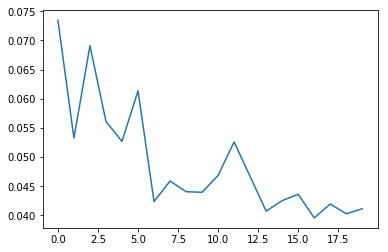

In [36]:
plt.plot(l[0]) 

### Note!!! add back grand mean for the exact predictions 

### Function 4: Decompose X_hat 

In [37]:
def Decompose_X(X):
    B_u = X[:,1]
    X_pure = X[:,2:]
    return [B_u, X_pure]

In [38]:
lx = Decompose_X(l[1])

In [39]:
lx[0].shape

(3487,)

In [40]:
lx[1].shape

(3487, 10)

### Function 5: Decompose Y_hat 

In [41]:
def Decompose_Y(Y):
    B_i = Y[0,:]
    Y_pure = Y[2:,:]
    return [B_i, Y_pure]

In [42]:
ly = Decompose_Y(l[2])

In [43]:
ly[0].shape

(590,)

In [44]:
ly[1].shape

(10, 590)